# Konkurs | 7 edycja kursu "Praktyczne uczenie maszynowe"


### Celem konkursu jest więcej samodzielnej pracy oraz dobra zabawa :)
Zadaniem konkursu jest zrobienie predykcji kosztu samochodów. Mamy dane historyczne (ogłoszenia sprzedaży samochodów) wraz z informacją o samochodzie.

Metryką sukcesu będzie: [MAE](https://en.wikipedia.org/wiki/Mean_absolute_error).

### Kaggle
Konkurs będzie dostępny na Kaggle - link do [konkursu](https://www.kaggle.com/t/535089da0b044e66958b286e73c7479e).

### Rejestracja
Jeśli jeszcze nie masz konta na Kaggle, to proszę [załóż konto](https://www.kaggle.com/).

Kaggle to jest największa społeczność uczenia maszynowego na świecie (póki co DataWorkshop jest tylko w Polsce, ale to pewnie się zmieni ;)). Dlatego jeśli chcesz zająć się tym na poważnie, zainspirować się lub od czasu do czasu brać udział w konkursach, to polecam założyć tam konto.

### Regulamin
1. Konkurs rozpoczyna się **19 października 2020 r.** i kończy się w niedzielę, **1 listopada 2020 r. o 23:59** (UTC).
2. Osoba, która będzie na pierwszym miejscu dostaje nagrodę - przenośny dysk, za drugie i trzecie miejsca będą kubki termiczne z logo DataWorkshop. Miejsca będą widoczne na Leader Board przez cały czas trwania konkursu.
3. Zbiór danych został podzielony na dwie części: publiczny i prywatny. Publiczny zbiór danych zawiera cechy + odpowiedź, prywatny zbiór tylko cechy. Należy zrobić predykcję na prywatnym zbiorze i wysłać na Kaggle. Gdy skończy się konkurs, to ostateczny wynik będzie na zbiorze prywatnym.
4. Dane są przygotowane w celach edukacyjnych, zakazane jest ich używanie w innym celu niż ten kurs oraz zakazane jest upublicznianie danych w dowolny sposób. Rozwiązanie ma być oparte tylko i wyłącznie przy użyciu uczenia maszynowego (trenowanie modelu na podstawie udostępnionych danych). Nie ma co kombinować, skup się na nauce :).
5. W tym konkursie nie można łączyć się w drużyny. Każdy uczestnik może dodać rozwiązanie (czyli zrobić tak zwany *submit*) do 5 prób rozwiązań w jeden dzień (dlatego warto zacząć wcześniej, będzie więcej prób).
6. Osoby, które zajmą 1, 2 oraz 3 miejsca opublikują wszystkim swoje rozwiązanie (w przeciągu tygodnia po wygranej) i udostępnią je podając link na Slacku.
7. Nagroda będzie wysłana do 4 tygodni na terenie Polski.


### Dane

W danych jest **160 616** wierszy, które zostały podzielone prawie na równe części:
- `train.car_price` (106 494 wierszy)
- `test.car_price` (54 122 wierszy)

Jak robisz `submit` na Kaggle, to jest wyliczany wynik. Zwróć uwagę, że wynik jest wyliczany tylko na 30% danych testowych i ten wynik jest widoczny na tak zwanym "Public Leader Board". 

![](../images/public_private.png)

W praktyce to oznacza, że w Twoim zbiorze treningowym są odpowiedzi, ale masz tak trenować model, aby móc go zwalidować najpierw lokalnie (czyli użyć np. walidację krzyżową lub coś bardziej zaawansowanego). Następnie wrzucasz swój wynik na Kaggle (jako plik csv). W ciągu dnia masz maksymalnie 5 prób (czym wcześniej zaczniesz robić konkurs, tym więcej będziesz mieć prób). W trakcie konkursu Twój wyliczony wynik jest sprawdzony tylko na części danych (w tym przypadku 30%). To jest tak zwany `Public Leader Board`.

Gdy konkurs się skończy, wynik będzie przeliczony na wszystkich dostępnych danych testowych i będzie dostępny na tak zwanym "Private Leader Board". Dlaczego tak się robi? Chodzi o to, że Twoje rozwiązanie powinno być jak najbardziej stabilne na jak najmniejszej jak i większej próbce danych. Dlatego musisz uważnie robić walidację, bo pierwsze miejsce na Public Leader Board nie musi być pierwszym na `Private Leader Board` :) Uważaj na to!


## Dane
To są prawdziwe dane.

**Uwaga!** Danych można używać tylko w **celach edukacyjnych** (również nie można ich publikować lub dzielić nimi z innymi)!

In [1]:
from mozo import get_price_value_from_pln_log_transl, merge_with_features, how_many_levels

In [2]:
import math 

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import r2_score, f1_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.dummy import DummyRegressor
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb

from scipy import stats

from scikitplot.estimators import plot_learning_curve

from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from functools import partial

import xgbfir

import matplotlib.pyplot as plt
%matplotlib inline

#np.random.seed(0)

import pandas as pd
train = pd.read_hdf('~/pml7/module3/input/train.car_price.h5')
test = pd.read_hdf('~/pml7/module3/input/test.car_price.h5') #zbiór testowy bez odpowiedzi

print(train.shape)
print(test.shape)
#train.to_csv('../../output/train.csv', index=False) 
#test.to_csv('../../output/test.csv', index=False) 


(106494, 155)
(54122, 153)


In [3]:
print(train.columns)
print(test.columns)
(train.columns).difference(test.columns)


Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-value',
       'car_id'],
      dtype='object', length=155)
Index(['breadcrumb', 'created_at', 'price_currency', 'seller_address',
       'seller_name', 'seller_type', 'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       'feature_kurtyny-powietrzne', 'feature_klimatyzacja-dwustrefowa',
       ...
       'param_pearl', 'param_stan', 'param_wersja', 'param_emisja-co2',
       'param_body-type', 'param_matowy', 'param_bezwypadkowy',
       'param_akryl-(niemetalizowany)', 'param_monthly-payment-va

Index(['price_details', 'price_value'], dtype='object')

In [4]:
train, test = merge_with_features('ft_created_at_unix_train.csv', train, test)
train, test = merge_with_features('ft_latitude_longitude_train.csv', train, test)
train, test = merge_with_features('ft_price_test.csv', train, test)


train
Index(['car_id', 'created_at_unix', 'created_at_unix_na_mean'], dtype='object')
test
Index(['car_id', 'created_at_unix', 'created_at_unix_na_mean'], dtype='object')
train
Index(['car_id', 'latitude', 'latitude_na_mean', 'longitude',
       'longitude_na_mean'],
      dtype='object')
test
Index(['car_id', 'latitude', 'latitude_na_mean', 'longitude',
       'longitude_na_mean'],
      dtype='object')
train
Index(['car_id', 'pln_to_eur', 'price_value_pln',
       'price_value_pln_log_transl'],
      dtype='object')
test
Index(['car_id', 'pln_to_eur'], dtype='object')


In [5]:
train, test = merge_with_features('ft_new_param_test.csv', train, test)


train
Index(['car_id', 'new_param_rok-produkcji', 'new_param_przebieg',
       'new_param_moc', 'new_param_liczba-drzwi', 'new_param_liczba-miejsc'],
      dtype='object')
test
Index(['car_id', 'new_param_rok-produkcji', 'new_param_przebieg',
       'new_param_moc', 'new_param_liczba-drzwi', 'new_param_liczba-miejsc'],
      dtype='object')


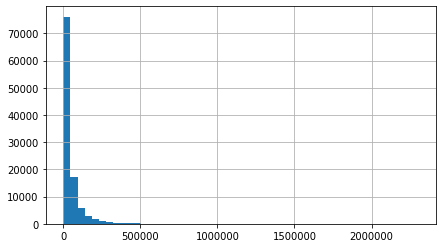

In [53]:
%matplotlib inline
# only in a Jupyter notebook
train['price_value_pln'].hist(bins=50, figsize=(7,4))
plt.show()

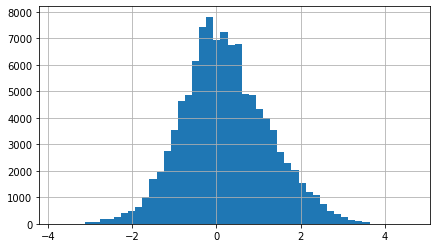

In [54]:
%matplotlib inline
# only in a Jupyter notebook
train['price_value_pln_log_transl'].hist(bins=50, figsize=(7,4))
plt.show()

In [ ]:
## New Model 

In [6]:
pd.options.display.max_seq_items = None

#train.shape
train.columns
#train.info()
#train.head()

Index(['breadcrumb', 'created_at', 'price_currency', 'price_details',
       'price_value', 'seller_address', 'seller_name', 'seller_type',
       'feature_czujniki-parkowania-przednie',
       'feature_poduszka-powietrzna-chroniąca-kolana',
       'feature_kurtyny-powietrzne', 'feature_klimatyzacja-dwustrefowa',
       'feature_światła-led', 'feature_czujnik-zmierzchu',
       'feature_elektrycznie-ustawiane-lusterka',
       'feature_asr-(kontrola-trakcji)',
       'feature_poduszka-powietrzna-kierowcy', 'feature_cd',
       'feature_elektryczne-szyby-przednie',
       'feature_poduszka-powietrzna-pasażera', 'feature_system-start-stop',
       'feature_światła-do-jazdy-dziennej', 'feature_komputer-pokładowy',
       'feature_elektryczne-szyby-tylne', 'feature_klimatyzacja-manualna',
       'feature_tapicerka-welurowa', 'feature_czujnik-deszczu',
       'feature_światła-przeciwmgielne', 'feature_ogrzewanie-postojowe',
       'feature_radio-niefabryczne', 'feature_regulowane-zawieszeni

In [82]:
for col in train.columns.tolist():
    if 'feature_' in col or 'seller_type' in col:
        print(col + ': ')
        print(collections.Counter(train[col])) 


seller_type: 
Counter({'Dealer': 64581, 'Osoba prywatna': 41804, None: 109})
feature_czujniki-parkowania-przednie: 
Counter({False: 79379, True: 27115})
feature_poduszka-powietrzna-chroniąca-kolana: 
Counter({False: 85868, True: 20626})
feature_kurtyny-powietrzne: 
Counter({True: 57729, False: 48765})
feature_klimatyzacja-dwustrefowa: 
Counter({False: 66165, True: 40329})
feature_światła-led: 
Counter({False: 83084, True: 23410})
feature_czujnik-zmierzchu: 
Counter({False: 64853, True: 41641})
feature_elektrycznie-ustawiane-lusterka: 
Counter({True: 90352, False: 16142})
feature_asr-(kontrola-trakcji): 
Counter({True: 64564, False: 41930})
feature_poduszka-powietrzna-kierowcy: 
Counter({True: 95140, False: 11354})
feature_cd: 
Counter({True: 85126, False: 21368})
feature_elektryczne-szyby-przednie: 
Counter({True: 95348, False: 11146})
feature_poduszka-powietrzna-pasażera: 
Counter({True: 93939, False: 12555})
feature_system-start-stop: 
Counter({False: 85775, True: 20719})
feature_świ

In [94]:
for col in train.columns.tolist():
    if 'param_' in col:
        if train[col].isna().sum() < 20_000:
            print('\n' + col + ': ')
            print(collections.Counter(train[col]).most_common(10)) 



param_liczba-miejsc: 
[('5', 81870), (None, 11911), ('7', 5310), ('4', 4571), ('2', 1130), ('9', 680), ('6', 399), ('8', 361), ('3', 259), ('1', 3)]

param_marka-pojazdu: 
[('Volkswagen', 11314), ('Opel', 9773), ('BMW', 8327), ('Audi', 7960), ('Ford', 7567), ('Renault', 6267), ('Mercedes-Benz', 5861), ('Toyota', 5088), ('Škoda', 4532), ('Peugeot', 4462)]

param_liczba-drzwi: 
[('5', 71489), ('4', 15174), (None, 9900), ('3', 7289), ('2', 2517), ('6', 96), ('7', 13), ('1', 6), ('9', 5), ('8', 4)]

param_przebieg: 
[('1 km', 4047), ('5 km', 2889), ('10 km', 1123), ('180 000 km', 878), ('190 000 km', 841), ('200 000 km', 838), ('220 000 km', 832), ('170 000 km', 804), ('230 000 km', 720), ('160 000 km', 671)]

param_rok-produkcji: 
[('2017', 11756), ('2007', 7490), ('2008', 7305), ('2006', 6938), ('2009', 6242), ('2005', 6201), ('2010', 5925), ('2014', 5776), ('2011', 5459), ('2004', 5229)]

param_kategoria: 
[('Osobowe', 106385), (None, 109)]

param_napęd: 
[('Na przednie koła', 66012), 

In [91]:
train['param_liczba-miejsc'].isna().sum()

11911

In [ ]:
- kraj
- 1sza rej
- przebieg
- uszko

In [ ]:
for col in train.columns: 
    if col.startswith('feature_'):
        print(col + ': ')
        train[col] = train.apply(lambda row: 1 if row[col] else 0, axis=1)

In [ ]:
for col in train.columns: 
    if col.startswith('feature_'):
        print(col + ': ')
        print(collections.Counter(train[col])) 
        print('')

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix


## Basic Model

In [ ]:
feats = ['car_id']  ##cokolwiek na początek

model = DummyRegressor()
model.fit(train[ feats ].values, train['price_value'])
y_pred = model.predict(test[ feats ].values)

In [9]:
filter_col = ['latitude_na_mean', 'longitude_na_mean', 'new_param_rok-produkcji', 'new_param_przebieg',
       'new_param_moc', 'new_param_liczba-drzwi', 'new_param_liczba-miejsc',
'feature_bluetooth', 
'feature_kamera-cofania', 
'feature_światła-led', 
'feature_system-start-stop', 
'feature_czujniki-parkowania-przednie', 
'feature_światła-do-jazdy-dziennej', 
'feature_poduszka-powietrzna-kierowcy', 
'feature_łopatki-zmiany-biegów', 
'feature_esp-(stabilizacja-toru-jazdy)', 
'feature_wspomaganie-kierownicy', 
'feature_czujniki-parkowania-tylne', 
'feature_tapicerka-welurowa', 
'feature_cd', 
'feature_tempomat', 
'feature_radio-fabryczne', 
'feature_gniazdo-usb', 
'feature_nawigacja-gps', 
'feature_isofix']  

xgb_rmodel = xgb.XGBRegressor().fit(train[filter_col], train['price_value_pln_log_transl'])
xgbfir.saveXgbFI(xgb_rmodel, feature_names=filter_col, OutputXlsxFile='../../output/mixed_some_feature_new_param_1_XgbFI.xlsx')
pd.read_excel('../../output/mixed_some_feature_new_param_1_XgbFI.xlsx', 'Interaction Depth 0')

,Interaction,Gain,FScore,wFScore,Average wFScore,Average Gain,Expected Gain,Gain Rank,FScore Rank,wFScore Rank,Avg wFScore Rank,Avg Gain Rank,Expected Gain Rank,Average Rank,Average Tree Index,Average Tree Depth
0,new_param_rok-produkcji,142327.920503,861,82.850949,0.096226,165.305366,119917.215618,1,3,4,14,1,1,4.000000,47.331010,3.938444
1,new_param_moc,44203.567342,979,121.566454,0.124174,45.151754,13330.346364,2,1,1,4,2,2,2.000000,42.417773,3.941777
2,new_param_przebieg,3293.460100,812,78.198424,0.096303,4.055985,438.901830,3,4,5,12,16,3,7.166667,51.500000,4.099754
3,longitude_na_mean,1810.747059,751,103.667455,0.138039,2.411115,259.309911,4,5,3,2,23,6,7.166667,52.885486,3.912117
4,latitude_na_mean,1553.565322,921,111.065713,0.120593,1.686824,264.628667,5,2,2,5,25,5,7.333333,53.935939,4.039088
5,feature_esp-(stabilizacja-toru-jazdy),979.101897,66,5.492394,0.083218,14.834877,165.969136,6,9,10,19,6,9,9.833333,46.878788,4.151515
6,feature_czujniki-parkowania-przednie,799.091244,53,3.940992,0.074358,15.077193,107.591482,7,15,14,20,5,13,12.333333,33.830189,4.094340
7,new_param_liczba-miejsc,798.932272,176,22.084859,0.125482,4.539388,138.097816,8,6,6,3,13,11,7.833333,43.255682,3.920455
8,feature_czujniki-parkowania-tylne,637.293458,35,1.526574,0.043616,18.208385,203.017710,9,21,25,24,4,7,15.000000,41.428571,4.114286
9,feature_tempomat,614.787229,62,3.102851,0.050046,9.915923,128.699265,10,10,20,22,9,12,13.833333,47.806452,4.129032


In [26]:
def objective(space):
    
    model_params = {
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'learning_rate': space['learning_rate'],
        #'random_state': int(space['random_state']),
        'verbose' : False,
        'random_state': 3400
    }
    
    model = ctb.CatBoostRegressor(**model_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('max_depth', 1, 16, 1),
    'n_estimators': hp.quniform ('n_estimators', 1, 500, 1),
    'learning_rate': hp.uniform ('learning_rate', 0.01, 1.),
    #'random_state': hp.quniform ('random_state', 0, 10000, 50),
}


In [43]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
#best_params['random_state'] = int(best_params['random_state'])
best_params['learning_rate'] = int(best_params['learning_rate'])
print(best_params)


{'colsample_bytree': 0.15830296911131203, 'learning_rate': 0.15967809304747654, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 498, 'reg_alpha': 1.0041318883734858, 'reg_lambda': 0.1560121612225981, 'subsample': 0.9968592366017129}


In [61]:
filter_col = ['latitude_na_mean', 'longitude_na_mean', 'new_param_rok-produkcji', 'new_param_przebieg',
       'new_param_moc', 'new_param_liczba-drzwi', 'new_param_liczba-miejsc', *[col for col in train if col.startswith('feature_')]] 
            

In [62]:
filter_col

['latitude_na_mean',
 'longitude_na_mean',
 'new_param_rok-produkcji',
 'new_param_przebieg',
 'new_param_moc',
 'new_param_liczba-drzwi',
 'new_param_liczba-miejsc',
 'feature_czujniki-parkowania-przednie',
 'feature_poduszka-powietrzna-chroniąca-kolana',
 'feature_kurtyny-powietrzne',
 'feature_klimatyzacja-dwustrefowa',
 'feature_światła-led',
 'feature_czujnik-zmierzchu',
 'feature_elektrycznie-ustawiane-lusterka',
 'feature_asr-(kontrola-trakcji)',
 'feature_poduszka-powietrzna-kierowcy',
 'feature_cd',
 'feature_elektryczne-szyby-przednie',
 'feature_poduszka-powietrzna-pasażera',
 'feature_system-start-stop',
 'feature_światła-do-jazdy-dziennej',
 'feature_komputer-pokładowy',
 'feature_elektryczne-szyby-tylne',
 'feature_klimatyzacja-manualna',
 'feature_tapicerka-welurowa',
 'feature_czujnik-deszczu',
 'feature_światła-przeciwmgielne',
 'feature_ogrzewanie-postojowe',
 'feature_radio-niefabryczne',
 'feature_regulowane-zawieszenie',
 'feature_ogranicznik-prędkości',
 'feature_

In [56]:
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'n_estimators': int(space['n_estimators']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        'subsample': space['subsample'],
        'random_state': int(space['random_state']),
        'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'objective': 'reg:squarederror',
        'random_state': 3400
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('max_depth', 1, 100, 1),
    'n_estimators': hp.quniform ('n_estimators', 1, 500, 1),
    'colsample_bytree': hp.uniform ('colsample_bytree', 0.1, 1.),
    'learning_rate': hp.uniform ('learning_rate', 0.05, 1.0),
    'subsample': hp.uniform ('subsample', 0.1, 1.),
    'random_state': hp.quniform ('random_state', 0, 10000, 50),
    'min_child_weight': hp.quniform ('min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('reg_lambda', 0.1, 1.),
}


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(train[filter_col],
                                                    train['price_value_pln_log_transl'], test_size=0.3)

trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=1),
            max_evals=100,
            trials=trials)

print("The best params: ", best_params)

  9%|▉         | 9/100 [08:51<1:00:11, 39.69s/trial, best loss: 0.23055343168328196]

In [ ]:
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])
best_params['random_state'] = int(best_params['random_state'])
best_params['min_child_weight'] = int(best_params['min_child_weight'])
print(best_params)


In [ ]:
model = ctb.CatBoostRegressor(n_estimators=100, depth=10, random_state=3400, verbose=False)
#model = RandomForestRegressor(max_depth=10, n_estimators=150, max_features=0.8)
#model = xgb.XGBRegressor(**best_params)

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae)
print(r2)
plot_learning_curve(model, train[filter_col], train['price_value_pln_log_transl'], cv=3, random_state=0, shuffle=True)

In [ ]:
plt.hist(y_test - y_pred, bins=50);

In [ ]:
get_price_value_from_pln_log_transl('mixed_some_feature_new_param_1__test_2', test, filter_col, model, 
                                    {"mean_absolute_error" : mae, "r2_score" : r2, "best_params" : best_params, 
                                    "opis" : ""})

## Submission
Trzeba przygotować plik, który będzie zawierał: `car_id` i `price`.

In [56]:
X_train, X_test, y_train, y_test = train_test_split(train['car_id'], train['price_value_pln_log_transl'], test_size=0.3)

model = DummyRegressor(strategy='median')

%time model.fit(X_train, y_train)
%time y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(mae)
print(r2)

get_price_value_from_pln_log_transl('test', test, ['car_id'], model, mae, r2, details=None)

CPU times: user 1.51 ms, sys: 341 µs, total: 1.85 ms
Wall time: 1.73 ms
CPU times: user 960 µs, sys: 217 µs, total: 1.18 ms
Wall time: 866 µs
0.8140458262370148
-0.005614372502695364


![](../images/dummy_benchmark.png)